In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the data

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/ACV/Dataset- Images.npy'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
data = np.load(path, allow_pickle = True)

In [5]:
data[1][0]

array([[[207, 216, 227, 255],
        [206, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  32,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 215, 227, 255],
        ...,
        [ 35,  33,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       ...,

       [[ 31,  21,  17, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31

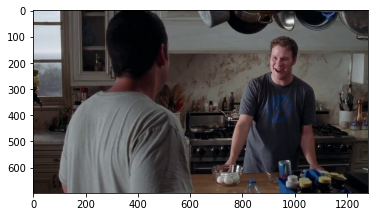

In [6]:
plt.imshow(data[1][0])

In [7]:
data[1][1]

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

### Feature and Label

In [8]:
import tensorflow as tf
def normalize_data(img):
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

In [9]:
masks = np.zeros((int(data.shape[0]), 224, 224))
X_train = np.zeros((int(data.shape[0]), 224, 224, 3))

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (224, 224), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = normalize_data(np.array(img, dtype = np.float32))

    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * 224)
        x2 = int(i['points'][1]['x'] * 224)
        y1 = int(i['points'][0]['y'] * 224)
        y2 = int(i['points'][1]['y'] * 224)
        masks[index][y1 : y2, x1 : x2] = 1

In [10]:
np.unique(masks)

array([0., 1.])

In [11]:
X_train[0]

array([[[-0.57647061, -0.6156863 , -0.63921571],
        [-0.41960782, -0.4588235 , -0.48235291],
        [-0.54509807, -0.57647061, -0.60784316],
        ...,
        [-0.79607844, -0.71764708, -0.70980394],
        [-0.84313726, -0.7647059 , -0.7647059 ],
        [-0.80392158, -0.72549021, -0.71764708]],

       [[-0.60784316, -0.64705884, -0.67058825],
        [-0.4588235 , -0.49803919, -0.52156866],
        [-0.49803919, -0.53725493, -0.56078434],
        ...,
        [-0.8509804 , -0.81960785, -0.83529413],
        [-0.8509804 , -0.81176472, -0.83529413],
        [-0.75686276, -0.72549021, -0.74117649]],

       [[-0.60784316, -0.64705884, -0.67058825],
        [-0.51372552, -0.5529412 , -0.57647061],
        [-0.52941179, -0.56862748, -0.59215689],
        ...,
        [-0.77254903, -0.78823531, -0.82745099],
        [-0.7647059 , -0.78039217, -0.81960785],
        [-0.73333335, -0.74901962, -0.78823531]],

       ...,

       [[-0.50588238, -0.57647061, -0.63137257],
        [-0

In [12]:
masks.shape

(409, 224, 224)

In [13]:
X_train.shape

(409, 224, 224, 3)

### U-Net

In [14]:
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [15]:
def mobv2_model(trainable = True):

    model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3),
                                              alpha = 1.0,
                                              include_top = False,
                                              weights = 'imagenet')

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer('block_1_expand_relu').output
    block2 = model.get_layer('block_3_expand_relu').output
    block3 = model.get_layer('block_6_expand_relu').output
    block4 = model.get_layer('block_13_expand_relu').output
    block5 = model.get_layer('out_relu').output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size = 1, activation = 'sigmoid')(x)

    x = Reshape((224, 224))(x)
    return Model(inputs = model.input, 
                 outputs = x)

In [16]:
model = mobv2_model()

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Dice Coefficient & Loss Function

In [18]:
from keras import backend as K

In [19]:
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

In [20]:
# def dice_coefficient(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred)
#     denominator = tf.reduce_sum(y_true + y_pred)
#     return numerator / (denominator + tf.keras.backend.epsilon())

In [21]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [22]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [23]:
model.compile(optimizer = 'adam', loss = loss, metrics = [dice_coefficient])

### Train & Evaluation

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [25]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ACV/Weights/model-{loss:.2f}.h5', 
                             monitor = 'loss', 
                             verbose = 1, 
                             save_best_only = True,
                             save_weights_only = True, 
                             mode = 'min', 
                             save_freq = 1)

In [26]:
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')

In [27]:
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

In [ ]:
model.fit(X_train, masks,
          epochs = 10,
          batch_size = 1,
          validation_split = 0.1,
          callbacks=[checkpoint, reduce_lr, stop],
          verbose = 1)

Streaming output truncated to the last 5000 lines.
Epoch 00004: loss did not improve from 0.51701
 84/368 [=====>........................] - ETA: 6:05 - loss: 0.7195 - dice_coefficient: 0.6358
Epoch 00004: loss did not improve from 0.51701
 85/368 [=====>........................] - ETA: 6:04 - loss: 0.7161 - dice_coefficient: 0.6371
Epoch 00004: loss did not improve from 0.51701
 86/368 [======>.......................] - ETA: 6:02 - loss: 0.7208 - dice_coefficient: 0.6344
Epoch 00004: loss did not improve from 0.51701
 87/368 [======>.......................] - ETA: 6:01 - loss: 0.7239 - dice_coefficient: 0.6353
Epoch 00004: loss did not improve from 0.51701
 88/368 [======>.......................] - ETA: 6:00 - loss: 0.7201 - dice_coefficient: 0.6364
Epoch 00004: loss did not improve from 0.51701
 89/368 [======>.......................] - ETA: 5:59 - loss: 0.7163 - dice_coefficient: 0.6385
Epoch 00004: loss did not improve from 0.51701
 90/368 [======>.......................] - ETA: 5:

### Prediction

In [28]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/ACV/Weights/model-0.26.h5')

In [98]:
sample = 5
sample_img = X_train[sample]
sample_mask = masks[sample]

In [99]:
sample_img.shape, sample_mask.shape

((224, 224, 3), (224, 224))

In [100]:
sample_img_resize = np.resize(sample_img, (1, 224, 224, 3))
# sample_mask_resize = np.resize(sample_mask, (224, 224))

In [101]:
prediction = model.predict(sample_img_resize)

In [102]:
pred_resize = np.resize(prediction, (224 , 224))

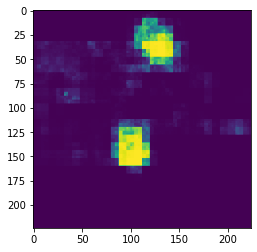

In [103]:
plt.imshow(pred_resize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


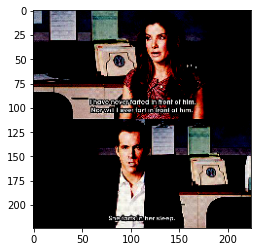

In [104]:
img = np.resize(sample_img, (224, 224, 3))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


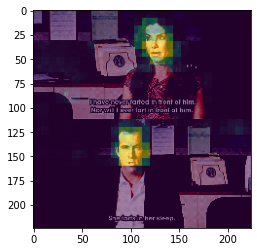

In [126]:
plt.imshow(img)
plt.imshow(pred_resize, alpha = 0.5)

### Conclusion

This project is about finding out the mask of the image using CNN's pre-trained transfer learning model - MobileNet V2.
 

* First we imported the data (images) into numpy array, then created a custom snippet to imported the mask and visualize both.
*   Second, defined the U-shape model using MobileNet backbone.
* After that, wrote the custom functions and inserted them into the defined model.
* After training, we got a loss of 0.26 with a dice coefficient of 0.72. While in the evaluation, it got a loss of 1.14 with a dice-coefficient of 0.52.
* The model's score is adequate and needs to be improved with more hyper tuning.
* At last, we can see that the image has been predicted the mask and has been displayed on the original image.